In [1]:
#library
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import inspect

import pickle
from collections import Counter, defaultdict
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error,pairwise_distances
# from metrics import pairwise_distance
from math import sqrt
import math

#import reader
# import slurp
#import gumbel as gb
import pandas as pd


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
from numpy import genfromtxt


# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # disable when using tf.Print
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/bo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#read the synthetic data
pretrained_emb = genfromtxt('synthetic-2000-g.csv', delimiter=',')

In [3]:
#split the dat into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(pretrained_emb, test_size=0.2, random_state=0)
pretrained_emb = X_train
pretrained_emb.shape, X_test.shape

((1280, 2), (320, 2))

In [4]:
#get examplars
center_K0 = 200
kmeans = KMeans(n_clusters=center_K0, init='k-means++').fit(pretrained_emb) #k_centers
kmeans.labels_

k_centers = kmeans.cluster_centers_

k_centers.shape #, k_centers

(200, 2)

In [5]:
#get neighbors' indexes
n = len(pretrained_emb)
neighbors = []
nei_num = 10
# all_dis = np.zeros((int(n), (int)(center_K0+nei_num)))
for x in range(n):
    dis = pairwise_distances([pretrained_emb[x]], pretrained_emb)
    idxes = np.argpartition(dis[0], nei_num+1)
    new_idxes = np.delete(idxes, np.argwhere(idxes==x))
    nei_emb = pretrained_emb[new_idxes[0:nei_num]]
    tmp_d = pairwise_distances([pretrained_emb[x]], nei_emb)
#     all_dis[x] = np.append(Dis[x],tmp_d)
    neighbors.append(new_idxes[0:nei_num])
#     print(new_idxes[0:nei_num])
    
neighbors = np.array(neighbors)


In [6]:
#support functions, calculate the P, distances and Q
import math
import numpy as np
import torch
from time import time
from torch.nn import functional as F
from joblib import Parallel, delayed
# from sklearn.metrics import pairwise_distances #, pairwise_distances_nn

EPS_F64 = 1e-87 # float(np.finfo(np.double).eps)
EPS_F32 = 1e-23 # float(np.finfo(np.float32).eps)
EPS_DBL = 1e-8
ENTROPY_DIFF_TOL = 1e-4

#Poincare distances
def poincare_pairwise_dis(x, y):
    n, m = x.shape[0], y.shape[0]
    Dis = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            Dis[i][j] = np.arccosh(1+2*((np.linalg.norm(x[i]-y[j]))**2)/((1-((np.linalg.norm(x[i]))**2))*(1-((np.linalg.norm(y[j]))**2))))
#             if np.isnan(Dis[i][j]):
#                 Dis[i][j] = np.Inf
    return Dis

def poincare_pairwise_dis2(x, y):
    n, m = x.shape[0], y.shape[1]
    Dis = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            Dis[i][j] = np.arccosh(1+2*((np.linalg.norm(x[i]-y[i][j]))**2)/((1-((np.linalg.norm(x[i]))**2))*(1-((np.linalg.norm(y[i][j]))**2))))
#             if np.isnan(Dis[i][j]):
#                 Dis[i][j] = np.Inf
    return Dis
                 

def joint_probabilities_exe_H(D, K=None, perplexity=10, verbose=False):
    """Compute joint probabilities p_ij from distances to/from and between exemplars.

    Args:
        D (Tensor): symmetric (N+K)x(N+K) or one-sided NxK pairwise distances to each other or exemplars.
        K (int): Number of exemplars.
        perplexity (float): Expected number of nearest neighbors
        verbose (int): Verbosity level
    
    Returns:

        P (Tensor): NxN joint probability matrix.
    """

    N = D.shape[0]
#     print(D.shape, D)
    P = torch.zeros_like(D)
    if K:
        # Compute symmetric joint probabilities to approximate the desired perplexity
        Ps = [P[0:N-K, 0:N-K], P[0:N-K, N-K:], P[N-K:, 0:N-K], P[N-K:, N-K:]]   # LT, RT, LB, RB
        Ds = [D[0:N-K, 0:N-K], D[0:N-K, N-K:], D[N-K:, 0:N-K], D[N-K:, N-K:]]
        for i, (ds, ps) in enumerate(zip(Ds, Ps)):
            if i > 0:
                ps = search_perplexity(ds, perplexity, verbose=False) 
                Ps[i].copy_(ps)

        P = (P + P.t()) / 2
        sum12 = (Ps[1] + Ps[2].t()).sum()
        Ps[1] /= sum12
        Ps[2] /= sum12
        Ps[3] /= Ps[3].sum()
    else:
        # Compute one-sided joint probabitlities from distances to exemplars
        P  = search_perplexity(D, perplexity, verbose=verbose)
        P /= P.sum()

    return P

def joint_probabilities_exe_L(D, K=None, alpha=1):
    # Q is a heavy-tailed distribution: Student's t-distribution
    N = D.shape[0]
    Q = 1 / (1 + D)
    Q.view(-1)[0::N+1] = 0
    if K:
        # Compute symmetric joint probabilities in t-distribution
        # XXX D.shape: (N+K)x(N+K) with E
        Ds = [D[0:N-K, 0:N-K], D[0:N-K, N-K:], D[N-K:, 0:N-K], D[N-K:, N-K:]]
        Qs = [Q[0:N-K, 0:N-K], Q[0:N-K, N-K:], Q[N-K:, 0:N-K], Q[N-K:, N-K:]]
        Qs12   = Qs[1].sum() + Qs[2].sum()
        Qs[0].zero_()
        Qs[1] /= Qs12
        Qs[2] /= Qs12
        Qs[3] /= Qs[3].sum()
    else:
        # Compute one-sided joint probabilities from distances to exemplars
        Q /= Q.sum()

    return Q

def joint_probabilities_nn_H(D, knn=None, perplexity=10, compact=True, verbose=False):
    #  FIXME KNN requires to consider all knn pairs?
    """Compute joint probabilities p_ij from distances to/from each other or knn.
    
	This method is approximately equal to joint_probabilities(). 
	The latter is O(N), but limiting the joint probability to nearest neighbors improves
    this substantially to O(uN).

	Args:
		distances (Tensor): NxN or Nxk pairwise distances to each other or knn.
		knn (Tensor): knn indices to gather or None if one-sided.
		perplexity (float): Expected number of nearest neighbors.
        compact (bool): wether to return compact P with knn only.
		verbose (bool): Print debug messages or not.
    
	Returns:
        P (Tensor): NxN or Nxk joint probability matrix P.
    """
    
    P = torch.zeros_like(D)
    if knn is None:
        P  = search_perplexity(D, perplexity, verbose=verbose)
        P  = P / P.sum()
        return P
    else:
        # Compute conditional probabilities to approximate the desired perplexity
        Dxnn = D.gather(1, knn) # excluding self
        Pc  = search_perplexity(Dxnn, perplexity, verbose=verbose)

        P.scatter_(1, knn, Pc)
        P  = (P + P.t()) / 2
        P /= P.sum()

        assert (P > 1).sum().item() == 0
        return P.gather(1, knn) if compact else P

def joint_probabilities_nn_L(D, knn=None, compact=True, verbose=False):
    #  FIXME no considering symmetric version?
    """Compute one-sided joint probabilities q_ij from distances using ordered knn.
    
	Args:
		distances (Tensor): NxN or Nxk pairwise distances to each other or k-nearest neighbors.
		knn (Tensor): Nxk indices to k-nearest neighbors.
        compact (bool): wether to return compact Nxk or NxN P.
		verbose (bool): Print debug messages or not.
    
	Returns:
        Q (Tensor): NxN or Nxk joint probability matrix Q.
    """

    if knn is None:
        Q  = 1 / (1 + D)
        Q /= Q.sum()
        return Q
    else:
        # Compute conditional probabilities to approximate the desired perplexity
        Dxnn = D.gather(1, knn)
        Qc  = 1 / (1 + Dxnn)
        assert torch.isnan(Qc).sum().item() == 0, "All probabilities should be finite"

        Q  = torch.zeros_like(D)
        Q.scatter_(1, knn, Qc)
        Q  = (Q + Q.t()) / 2
        Q  = Q / Q.sum()
        assert (Q > 1).sum() == 0
        return Q.gather(1, knn) if compact else Q

def search_perplexity(affinities, perplexity, steps=50, verbose=False):
    """Binary search for sigmas of conditional Gaussians.
        
    This approximation reduces the computational complexity from O(N^2) to
    O(uN). See the exact method '_binary_search_perplexity' for more details.

    Args:
        affinities (Tensor): Distances between training examples
        perplexity (float): Desired perplexity (2^entropy) of the conditional Gaussians.
        verbose (bool): Flag to print debug message.

    Returns:
        P (Tensor): Conditional probabilities of Gaussian distributions p_i|j.

	References:
		https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/_utils.pyx
    """
    
    # Precisions of conditional Gaussian distributions = 1/sigma^2
    N, K    = affinities.shape
    P       = torch.zeros_like(affinities)
    betas   = torch.ones(N, 1)

    # Parallel search in GPU
#     t0       = time()
    entropy  = math.log(perplexity)
    workload = 35000**2 // K // 2
    for offset in range(0, N, workload):
        to = min(offset + workload, N)
        Di = affinities[offset:to].double().cuda()
        Pi = P[offset:to].double().cuda()
        beta_i   = betas[offset:to].double().cuda()
        beta_min = torch.full_like(beta_i, -math.inf)
        beta_max = torch.full_like(beta_i, math.inf)
        #print(f'Parallel search for entropy {entropy:.2f} from {offset} to {to}...')

        # Binary search of precision for i-th conditional distribution
        for step in range(steps):
            # Compute current entropy and corresponding probabilities
            # computed just over the nearest neighbors or over all data
            # if we're not using neighbors

            Pi.copy_((-Di * beta_i).exp_())                  # FIXME large Di and beta_i produce zeros
            Pi[Pi == 1] = 0                                 # set self to zero if any
            sumPi       = Pi.sum(dim=1, keepdim=True)          
            #sumPi[sumPi == 0] = EPS_F32                    # in case of zero which causes nan from 0/0
            Pi         /= sumPi

            Hi            = sumPi.log() + beta_i * (Di * Pi).sum(dim=1, keepdim=True) # normalized entropy
            entropy_diffs = Hi - entropy
            tol = entropy_diffs.abs() > ENTROPY_DIFF_TOL
            if tol.sum().item() == 0:
                break

            gt                   = tol & (entropy_diffs > 0)
            gtMaxInf             = gt & (beta_max == math.inf)
            gtNotMaxInf          = gt & (beta_max != math.inf)
            beta_min[gt]         = beta_i[gt]
            beta_i[gtMaxInf]    *= 2
            beta_i[gtNotMaxInf]  = (beta_i[gtNotMaxInf] + beta_max[gtNotMaxInf]).div_(2)

            lte                  = tol & (entropy_diffs <= 0)
            lteMinInf            = lte & (beta_min == -math.inf)
            lteNotMinInf         = lte & (beta_min != -math.inf)
            beta_max[lte]        = beta_i[lte]
            beta_i[lteMinInf]   /= 2
            beta_i[lteNotMinInf] = (beta_i[lteNotMinInf] + beta_min[lteNotMinInf]).div_(2)

        betas[offset:to].copy_(beta_i.float())
        P[offset:to].copy_(Pi.float())
        
    if verbose:
        betas = torch.tensor(betas).cuda()
        print("[t-SNE] Mean sigma: ",(1 / betas).sqrt().mean().item())
        print("[t-SNE] Min sigma:  ",(1 / betas).sqrt().min().item())
        print("[t-SNE] Max sigma:  ",(1 / betas).sqrt().max().item())

    return P.float()


def pairwise_distances0(X, Y=None, metric='sqeuclidean'):
    """Compute all pairs of distances between examples in both datasets.

    Args:
        X (tensor): NxD dataset
        Y (tensor): KxD dataset or None

    Returns:
        NxN or NxK pairwise distances on CPU.
    """

    Y = X if Y is None else Y
    X = X.view(X.shape[0], -1)
    Y = Y.view(Y.shape[0], -1)
    N, dim = X.size()
    K, _   = Y.size()
    X = X.unsqueeze(1) # Nx1xdim #.expand(N, K, dim) # repeat each x for Ny times
    Y = Y.unsqueeze(0) # 1xKxdim #.expand(N, K, dim) # expand Y in Nx tiles
    D = torch.zeros(N, K, device=X.device)
    SZ = max(25000**2 // (K * dim), 1)
    #print('pairwise_distances():', N, K, D.shape)
    if metric == 'sqeuclidean':
#         t0 = time()
        for offset in range(0, N, SZ):
            to = min(offset + SZ, N)
            Xc = X[offset:to].cuda()                    # SZ x 1 x dim
            Yc = Y.cuda().expand(to - offset, K, dim)   # SZ x K x dim 
            Dc = (Yc - Xc).pow_(2).sum(2)
            D[offset:to, :].copy_(Dc)
#         duration = time() - t0
        #print(f"Pairwise distances throughput={N / duration:.2f} examples/s")
    elif metric == 'euclidean':
        for i in range(0, N, SZ):
            offset  = i * SZ
            to      = min(offset + SZ, N)
            Yc = Y[offset:to].cuda()
            Xc = X[offset:to].cuda()
            Dc = ((Yc - Xc)**2).sum(2).sqrt()
            D[offset:to].copy_(Dc)
    else:
        assert False, 'Unknown metric {metric}'
    return D

def pairwise_distances2(X, Y=None, metric='sqeuclidean'):
    """Compute all pairs of distances between examples in both datasets.

    Args:
        X (tensor): NxD dataset
        Y (tensor): NxKxD dataset or None

    Returns:
        NxN or NxK pairwise distances on CPU.
    """

    Y = X if Y is None else Y
    X = X.view(X.shape[0], -1)
#     Y = Y.view(Y.shape[0], -1)
    N, dim = X.size()
#     print(Y.size())
    K   = Y.shape[1]
    X = X.unsqueeze(1) # Nx1xdim #.expand(N, K, dim) # repeat each x for Ny times
#     Y = Y.unsqueeze(0) # 1xKxdim #.expand(N, K, dim) # expand Y in Nx tiles
    D = torch.zeros(N, K, device=X.device)
    SZ = max(25000**2 // (K * dim), 1)
#     print("SZ:", SZ)
    #print('pairwise_distances():', N, K, D.shape)
    if metric == 'sqeuclidean':
#         t0 = time()
        for offset in range(0, N, SZ):
            to = min(offset + SZ, N)
#             print("TO:", to, Y.shape, X.shape)
            Xc = X[offset:to].cuda()                    # SZ x 1 x dim
            Yc = Y.cuda() #.view(to - offset, K, dim)   # SZ x K x dim 
            Dc = (Yc - Xc).pow_(2).sum(2)
            D[offset:to, :].copy_(Dc)
#         duration = time() - t0
        #print(f"Pairwise distances throughput={N / duration:.2f} examples/s")
    elif metric == 'euclidean':
        for i in range(0, N, SZ):
            offset  = i * SZ
            to      = min(offset + SZ, N)
            Yc = Y[offset:to].cuda()
            Xc = X[offset:to].cuda()
            Dc = ((Yc - Xc)**2).sum(2).sqrt()
            D[offset:to].copy_(Dc)
    else:
        assert False, 'Unknown metric {metric}'
    return D

In [7]:
#The whole training dataset
all_pretrained_emb = pretrained_emb
all_neighbors = neighbors

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

#generator
class PretrainData(Dataset):
    def __init__(self, d):
        self.dataset = d
        
    def __getitem__(self, index):
        data = self.dataset[index]
        
        return data, index

    def __len__(self):
        return len(self.dataset)

In [ ]:
#Training using examplars' and neighbors' P in one loop
from __future__ import print_function
import argparse
import torch as th
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Function, Variable
# from torchvision import datasets, transforms
# from torchvision.utils import save_image

th.backends.cudnn.benchmark = True


seed = 1
torch.manual_seed(seed)

# device = torch.device("cuda" if 1 else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if 1 else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)

class kd_ae(nn.Module):
    boundary = 1 - 1e-5
    eps = 1e-23
    def __init__(self, K, D, lng):
        super(kd_ae, self).__init__()
        #encode
        self.K = K
        self.D = D
        self.num_hidden = 20
        self.emb_lng = lng
        self.encode_d1 = nn.Linear(lng, int(self.num_hidden))
        self.sg1 = nn.Softplus()
        self.encode_d2 = nn.Linear(int(self.num_hidden), int(self.K*self.D))
        self.mx = nn.Softmax(-1)
        
        #decode
#         self.ae_dense = nn.Linear(int(self.K*self.D), 20)
        self.decode_d1 = nn.Linear(10, 5)
        self.sg2 = nn.Softplus()
        self.decode_d2 = nn.Linear(5, lng)
#         self.decode_d3 = nn.Linear(20, lng)
        self.decode_r1 = [nn.Linear(self.K, 10).cuda() for i in range(self.D)]
        self.decode_r2 = [nn.Linear(20, 2).cuda() for i in range(self.D-8)]
        de_w = [np.array([math.pow(2,-t)]) if t<4 else np.array([math.pow(2,-6)]) for t in range(self.D)]
        self.de_weight = [Variable(th.FloatTensor(de_w[i]), requires_grad=False).cuda() for i in range(self.D)]
        
        #KL
        kl_w = [math.pow(2,-t) if t<4 else np.array([math.pow(2,-6)]) for t in range(self.D) for i in range(self.K)]
        self.kl_weight = Variable(th.FloatTensor(kl_w), requires_grad=False).cuda()
                
    def encode(self, x, temperature, is_training):
        h1 = self.sg1(self.encode_d1(x)) #nn.Softplus()(
        logit = self.encode_d2(h1).view(-1, self.D, self.K)
        prob = self.mx(th.div(logit, temperature))
        code_soft = prob
        if is_training:
            code_prob = nn.Softmax(-1)(th.div(logit, temperature))
            code_dense = th.argmax(prob,dim=2).view(-1, self.D)
            return code_prob, code_soft, code_dense
        else:
            code_dense = th.argmax(prob,dim=2).view(-1, self.D)
            dense_idx = th.cuda.LongTensor(code_dense).view(-1,1)
#             print(code_dense.shape, dense_idx.shape, x.shape)
            code_onehot = th.cuda.FloatTensor(x.shape[0]*self.D, self.K).zero_().scatter_(1, dense_idx, 1).view(x.shape[0], self.D, self.K)
            code_prob = code_onehot
            with th.no_grad():
                code_prob = (code_prob-code_soft)+code_soft
            return code_prob, code_soft, code_dense #, code_onehot
        
    def decode(self, x):
#         input_list = [x[:, i, :].contiguous().view(-1, self.K) for i in range(self.D)]
# # #         print('III:', len(input_list))
        h_list = [self.decode_r1[i](x[:, i, :].contiguous().view(-1, self.K)) for i in range(self.D)]
    
        sqnorm = [th.clamp(th.sqrt(th.sum(h_list[i]**2, dim=-1))-self.eps, min=1).view(-1, 1) for i in range(self.D)]
        norm_list = [h_list[i]/sqnorm[i] for i in range(self.D)]
# #         output_list = norm_list #[h_list[i]/th.norm(h_list[i]) if th.norm(h_list[i])>0 else h_list[i] for i in range(self.D)]
        output_3d = th.stack([self.de_weight[i]*self.decode_d2(self.sg2(self.decode_d1(norm_list[i]))) for i in range(self.D)], dim=1)
# #         print(output_3d.shape)
        output_2d = th.sum(output_3d, dim=1)
    
#         print("output_2d", output_2d)
#         output_norm = th.clamp(th.sqrt(th.sum(output_2d[i]**2, dim=-1))-self.eps, min=1).view(-1, 1)
# # #         ou
#         output = output_2d #self.dense2(output_2d/output_norm) #self.dense2(th.sum(output_3d, dim=1))
#         print(x, th.mean(x, dim=1))
#         print(x.shape, th.mean(x, dim=1).shape)
#         x2_left = [self.decode_d2(self.sg2(self.decode_d1(x[:, i, :].contiguous().view(-1, self.K)))) for i in range(self.D)]
#         x2_right = [self.decode_r2[i](self.decode_r1[i](x[:, 8+i, :].contiguous().view(-1, self.K))) for i in range(self.D-8)]
#         x2_3d = th.stack([self.de_weight[i]*x2_left[i] for i in range(8)], dim=1)
#         x2_3d_2 = th.stack(x2_right, dim=1)
        
#         h1 = th.sum(x2_3d, dim=1) #th.sum(x, dim=2) th.mean(x2_3d, dim=1)
#         h2 = th.sum(x2_3d_2, dim=1)
#         h2 = self.decode_d2(h1)
        
#         output = h1 #+h2

        return output_2d, norm_list
    
    def cal_pairwise_distance(self, x, examplar):
        n_1, n_2 = x.size(0), examplar.size(0)
#         print(x, self.kl_weight)
        x = self.kl_weight*x
#         print(x)
        examplar = self.kl_weight*examplar
        norms_1 = torch.sum(x**2, dim=1, keepdim=True)
        norms_2 = torch.sum(examplar**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * x.mm(examplar.t())
#         print('pairwise:',distances_squared)
        return torch.sqrt(self.eps + torch.abs(distances_squared))

    def cal_pairwise_distance2(self, x, examplar):
        n_1, n_2 = x.size(0), examplar.size(0)
#         print('xxx:', x.shape, examplar.shape)
        x = self.kl_weight*x
#         print(x)
        examplar = self.kl_weight*examplar
        norms_1 = torch.sum(x**2, dim=1, keepdim=True)
        norms_2 = torch.sum(examplar**2, dim=1, keepdim=True)
#         print("norm2:",norms_2.shape)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * x.mm(examplar.t())
#         print('pairwise:',distances_squared)
        return torch.sqrt(self.eps + torch.abs(distances_squared))
    
    def KL(self, x, examplar, P):
        pairwise_distance = self.cal_pairwise_distance(x, examplar)
        Q = th.reciprocal(1+pairwise_distance)/th.sum(th.reciprocal(1+pairwise_distance))
#         print('SHAPE:',th.sum(P*th.log(th.tensor(P)), dim=-1).shape, Q.shape)
        KL_P = th.mean(th.sum(P*th.log(th.tensor(P)), dim=-1))
        KL_Q = th.mean(th.sum(th.tensor(P)*th.log(Q.double()),dim=-1))
#         print('Q',KL_P, KL_Q)
        return (KL_P.double()-KL_Q.double())

    def KL1(self, x, examplar, Pxe):
        Dxe  = self.cal_pairwise_distance(x, examplar)     # BxK
        Qxe  = joint_probabilities_exe_L(Dxe)  # BxK

        eps     = torch.tensor(EPS_F32).cuda()
        Pxe     = Pxe.max(eps)
        Qxe     = Qxe.max(eps)
        
#         print("Pxe:", Pxe.shape, Qxe.shape)
        KLDPxe  = (Pxe * Pxe.log()).sum()
        KLDQxe  = (-Pxe * Qxe.log()).sum()
        KLDxe   = KLDPxe + KLDQxe
#         print('Q',KL_P, KL_Q)
        return KLDxe


    def KL2(self, x, examplar, Pxe):
        Dxe  = pairwise_distances2(x, examplar)     # BxK
        Qxe  = joint_probabilities_exe_L(Dxe)  # BxK

        eps     = torch.tensor(EPS_F32).cuda()
        Pxe     = Pxe.max(eps)
        Qxe     = Qxe.max(eps)
        
#         print("Pxe:", Pxe.shape, Qxe.shape)
        KLDPxe  = (Pxe * Pxe.log()).sum()
        KLDQxe  = (-Pxe * Qxe.log()).sum()
        KLDxe   = KLDPxe + KLDQxe
#         print('Q',KL_P, KL_Q)
        return KLDxe
        
    
    def forward(self, x, examplar, ex_P, neighbor_examplar, ng_P, temperature, is_training):
        code_prob, code_soft, code_dense = self.encode(x, temperature, is_training)
        code_prob_exm, code_soft_exm, code_dense_exm = self.encode(examplar, temperature, is_training)

        hat_x, _ = self.decode(code_prob)
#         Dxe  = pairwise_distances0(x, examplar)    # BxK
#         Dxe  = self.cal_pairwise_distance(x, examplar)
#         Pxe  = joint_probabilities_exe_H(Dxe, perplexity=10)
        
        KL_loss = self.KL1(code_prob.view(-1,self.K*self.D), code_prob_exm.view(-1,self.K*self.D), ex_P) #self.KL(code_prob.view(-1,self.K*self.D), code_prob_exm.view(-1,self.K*self.D), P)
        
        code_prob_exm2, code_soft_exm2, code_dense_exm2 = self.encode(neighbor_examplar.view(-1,self.emb_lng), temperature, is_training)
#         print(x.shape, neighbor_examplar.shape, code_prob_exm2.shape)
#         Dxe2  = pairwise_distances2(x, neighbor_examplar)    # BxK
        
#         print(':::', x.shape, neighbor_examplar.shape)
#         Dxe  = self.cal_pairwise_distance(x, examplar)
#         Pxe2  = joint_probabilities_exe_H(Dxe2, perplexity=15)
        
        KL_loss2 = self.KL2(code_prob.view(-1,self.K*self.D), code_prob_exm2.view(-1,210,self.K*self.D), ng_P)
        return hat_x, KL_loss, KL_loss2
    
def loss_function(recon_x, x):
    return F.mse_loss(recon_x, x)


K = 32
D = 10

model = kd_ae(K, D, 2) #.to(device)
model = model.cuda()
lrate = 0.1
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

epoch = 500000
# def train(epoch, model):
model.train()
train_loss = 0
batch_size = 160
beta = 0 
beta2 = 1e0 

temperature = 1
t_step = (1-1e-2)/100000
lrate = 1
min_lr = 1
p_ls = 10.0



# for idx in range(10):
#     pretrained_emb = all_pretrained_emb[idx:500*(idx+1)]
#     neighbors = all_neighbors[idx:500*(idx+1)]
    
indexes = [x for x in range(len(all_pretrained_emb))]
examplars = Variable(torch.from_numpy(k_centers.astype(np.float32))).cuda()
batch_centers = np.array([k_centers for i in range(batch_size)])
batch_examplars = Variable(torch.from_numpy(batch_centers.astype(np.float32))).cuda()

batch_centers_t = np.array([k_centers for i in range(len(all_pretrained_emb))])
batch_examplars_t = Variable(torch.from_numpy(batch_centers_t.astype(np.float32))).cuda()
batch_neighbors_t = Variable(torch.from_numpy(all_pretrained_emb[neighbors].astype(np.float32))).cuda()
neighbor_examplar_t = th.cat((batch_examplars_t, batch_neighbors_t),1)

train_data = all_pretrained_emb.astype(np.float32)
data = Variable(torch.from_numpy(train_data)).cuda()

All_dis_exam = pairwise_distances0(data, examplars)
# All_dis_exam = Variable(torch.from_numpy(poincare_pairwise_dis(data, examplars))).cuda()
All_P_exam = joint_probabilities_exe_H(All_dis_exam, perplexity=5)

print('first')

All_dis_neighbor  = pairwise_distances2(data, neighbor_examplar_t)    # BxK        
# All_dis_neighbor  = Variable(torch.from_numpy(poincare_pairwise_dis2(data, neighbor_examplar_t))).cuda()
All_P_neighbor  = joint_probabilities_exe_H(All_dis_neighbor, perplexity=20)

print('second')



dataset = PretrainData(np.array(all_pretrained_emb))
emb_big_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)


for i in range(epoch):
#     print(i)
    for big_batch_idx, (pretrained_emb, indexes) in enumerate(emb_big_loader):
        batch_neighbors = Variable(torch.from_numpy(all_pretrained_emb[neighbors[indexes]].astype(np.float32))).cuda()
        neighbor_examplar = th.cat((batch_examplars, batch_neighbors),1)
        train_data = all_pretrained_emb[indexes].astype(np.float32)
        data = Variable(torch.from_numpy(train_data)).cuda() #.to(device)
    #         Pij = Variable(torch.from_numpy(P[indexes])).cuda()

        batch_ex_P = All_P_exam[indexes]
        batch_ng_P = All_P_neighbor[indexes]

    #         c_lr = lrate-i*(lrate-min_lr)/epoch
    #         optimizer = optim.RMSprop(model.parameters(), lr=c_lr)
    #         optimizer = optim.SGD(model.parameters(), lr=c_lr)
        optimizer.zero_grad()
        recon_batch, kl_loss, kl_loss2 = model.forward(data, examplars, batch_ex_P, neighbor_examplar, batch_ng_P, temperature, True)
    #         code_dense, recon_batch = model.forward(data, 1, True)
        loss = 0.1*loss_function(recon_batch, data).cpu().double()+beta2*kl_loss2.cpu().double() #+beta*kl_loss.cpu().double()
    #     print(loss)
        loss.backward()
    #         train_loss += loss.item()
        optimizer.step()
    #         if i%1000==1000-1:
    #         if i%10==9:
        temperature = max(1e-2, temperature-t_step)
        if i%5000==10-1:
            train_data = all_pretrained_emb.astype(np.float32)
            data = Variable(torch.from_numpy(train_data)).cuda()

            recon_batch, kl_loss, kl_loss2 = model.forward(data, examplars, All_P_exam, neighbor_examplar_t, All_P_neighbor, 1, False)
            loss = loss_function(recon_batch, data).double()
            print('epoch:', i, 'loss:', loss.double(), kl_loss, kl_loss2, temperature)
#             if p_ls<loss:
#                 break
#             else:
#                 p_ls = loss
            
#         if i%100==0 and i < 1000:
#             train_data = pretrained_emb.astype(np.float32)
#             data = Variable(torch.from_numpy(train_data)).cuda()
#             code_prob, code_soft, code_dense = model.encode(data, temperature, False)
#             recon_emb = model.decode(code_prob)
#             plt.figure(figsize=(20,10))
#             plt.scatter(recon_emb.cpu().detach().numpy()[:,0], recon_emb.cpu().detach().numpy()[:,1])
#             plt.savefig('draw/rst'+str(i)+'.png', bbox_inches='tight')
#             plt.close()
        

# train(1000000, model)




first
second
epoch: 9 loss: tensor(0.0703, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3280, device='cuda:0') tensor(1.1606, device='cuda:0') 0.9992772999999995
epoch: 9 loss: tensor(0.0702, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3281, device='cuda:0') tensor(1.1796, device='cuda:0') 0.9992673999999995
epoch: 9 loss: tensor(0.0700, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3300, device='cuda:0') tensor(1.1802, device='cuda:0') 0.9992574999999995
epoch: 9 loss: tensor(0.0698, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3328, device='cuda:0') tensor(1.1859, device='cuda:0') 0.9992475999999995
epoch: 9 loss: tensor(0.0696, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3305, device='cuda:0') tensor(1.1830, device='cuda:0') 0.9992376999999995
epoch: 9 loss: tensor(0.0694, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.3321,

In [18]:
#get the codes for the training dataset
dataset = PretrainData(np.array(all_pretrained_emb))
emb_big_loader = DataLoader(dataset, batch_size=200, shuffle=False, num_workers=1)

all_code = []
for big_batch_idx, (pretrained_emb, big_idx) in enumerate(emb_big_loader):
    code_prob, code_soft, code_dense = model.encode(pretrained_emb.float().cuda(), 1, False)
    code_dense = th.argmax(code_prob,dim=2).view(-1, D)
    if(len(all_code)==0):
        all_code = [code_dense]
    else:
        all_code.append(code_dense)
dense_codes = torch.cat(all_code, dim=0)

In [85]:
#Evaluate the nearest neighbors' precision 
k = 5
rst = []
final_cdd = dense_codes
for x in range(len(train_data)):
    Dis = pairwise_distances([train_data[x]], train_data)
    idxes = np.argpartition(Dis[0], k)
    match = [0 for fst in range(D)]
    for i in range(k):
#         print(final_cdd[x][0], idxes[i], final_cdd[idxes[i]][0])
        for first_c in range(D):
#             print(first_c)
            if ''.join([str(a) for a in final_cdd[x][:first_c]])==''.join([str(a) for a in final_cdd[idxes[i]][:first_c]]):
                match[first_c]+=1
    rst.append(match)
    
for first_c in range(D):
    print(first_c, np.average((np.array(rst)/k)[:,first_c]))
    
k = 10
rst = []
final_cdd = dense_codes
for x in range(len(train_data)):
    Dis = pairwise_distances([train_data[x]], train_data)
    idxes = np.argpartition(Dis[0], k)
    match = [0 for fst in range(D)]
    for i in range(k):
#         print(final_cdd[x][0], idxes[i], final_cdd[idxes[i]][0])
        for first_c in range(D):
#             print(first_c)
            if ''.join([str(a) for a in final_cdd[x][:first_c]])==''.join([str(a) for a in final_cdd[idxes[i]][:first_c]]):
                match[first_c]+=1
    rst.append(match)
    
for first_c in range(D):
    print(first_c, np.average((np.array(rst)/k)[:,first_c]))
    
k = 20
rst = []
final_cdd = dense_codes
for x in range(len(train_data)):
    Dis = pairwise_distances([train_data[x]], train_data)
    idxes = np.argpartition(Dis[0], k)
    match = [0 for fst in range(D)]
    for i in range(k):
#         print(final_cdd[x][0], idxes[i], final_cdd[idxes[i]][0])
        for first_c in range(D):
#             print(first_c)
            if ''.join([str(a) for a in final_cdd[x][:first_c]])==''.join([str(a) for a in final_cdd[idxes[i]][:first_c]]):
                match[first_c]+=1
    rst.append(match)
    
for first_c in range(D):
    print(first_c, np.average((np.array(rst)/k)[:,first_c]))
    
    
for i in range(D):
    tmp = {}
    for x in range(len(train_data)):
        key = ''.join([str(a) for a in final_cdd[x][:i]])
        if key in tmp:
            tmp[key] += 1
        else:
            tmp[key] = 1
    complx = 0
    for key, value in tmp.items():
        complx += value/len(train_data)*(value-1)
    print(i, ':', complx, ':', len(train_data), complx/len(train_data))

0 1.0
1 1.0
2 1.0
3 0.99921875
4 0.99921875
5 0.99921875
6 0.99921875
7 0.99921875
8 0.98546875
9 0.98125
10 0.9784375
11 0.971875
12 0.971875
13 0.971875
14 0.971875
15 0.95359375


IndexError: index 5154 is out of bounds for dimension 0 with size 1280

epoch: 120009 loss: tensor(0.0001, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>) tensor(3.1461, device='cuda:0') tensor(1.6180, device='cuda:0') 0.001


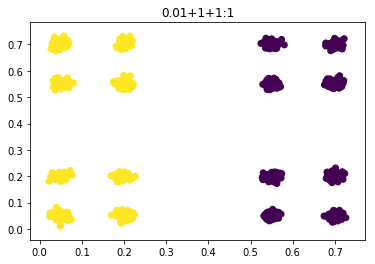

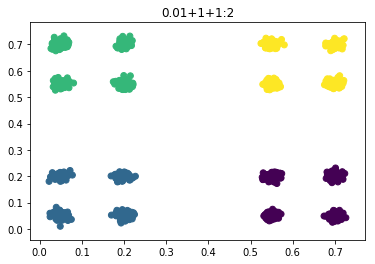

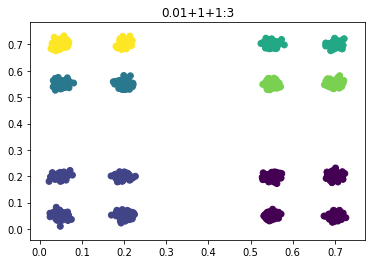

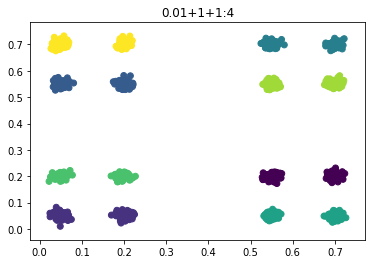

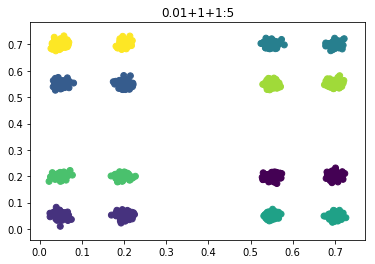

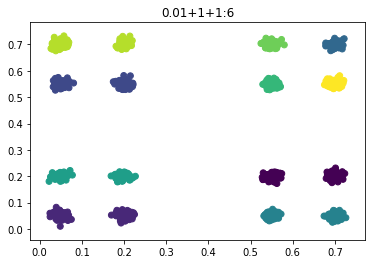

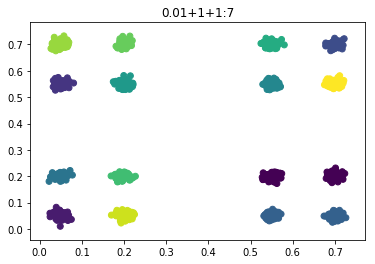

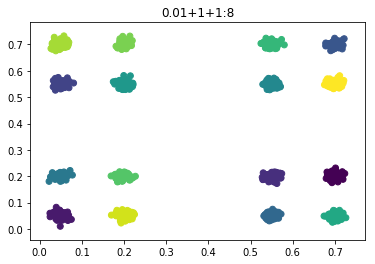

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 237, in _feed
    close()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


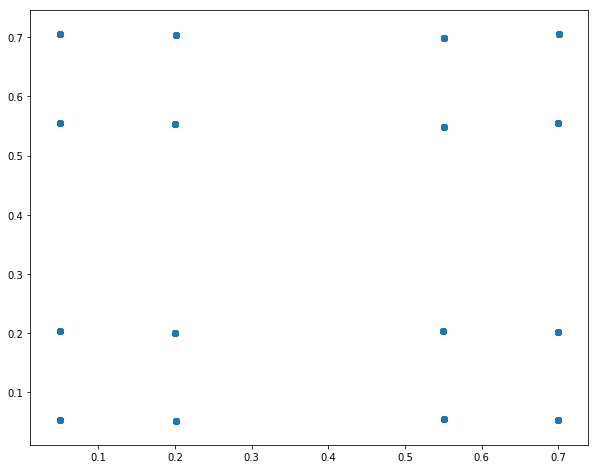

In [27]:
#plot the code figures
for first in range(1,9):
    u_codes = []
    colors = []
    for x in dense_codes[:,0:first].cpu().detach().numpy():
    #     print(type(colors),len(colors))
        tmp = ''.join([str(a) for a in x])

        if len(colors)==0:
            colors = [tmp]
            u_codes = [tmp]
            continue
        colors.append(tmp)
        u_codes.append(tmp)

    df = pd.DataFrame(data=colors)
    df2 = pd.Categorical(df[0], categories=df[0].unique()).codes
    mx = np.max(df2)
    df2 = df2*255/mx    

    plt.figure(figsize=(6,4))
    plt.scatter(all_pretrained_emb[:,0], all_pretrained_emb[:,1], c=df2)

In [77]:
#search complexity
final_cdd = dense_codes
for i in range(1,D):
    tmp = {}
    complx = 0
    for x in range(len(pretrained_emb)):
        key = ''.join([str(a) for a in final_cdd[x][:i]])
        if key in tmp:
            tmp[key] += 1
        else:
            tmp[key] = 1
       
    for key, value in tmp.items():
        complx += value/len(pretrained_emb)*(value-1)
    print(i, ':', complx, ':', len(pretrained_emb), complx/len(pretrained_emb))

0 : 1279.0 : 1280 0.99921875
1 : 381.73281249999997 : 1280 0.29822875976562496
2 : 96.02812500000005 : 1280 0.07502197265625003
3 : 66.1640625 : 1280 0.051690673828125
4 : 36.787499999999895 : 1280 0.028740234374999916
5 : 8.289062500000005 : 1280 0.006475830078125004
6 : 1.2281249999999977 : 1280 0.0009594726562499982
7 : 0.24062499999999992 : 1280 0.00018798828124999995
8 : 0.051562500000000004 : 1280 4.0283203125e-05
9 : 0.0203125 : 1280 1.5869140625e-05
10 : 0.009375 : 1280 7.32421875e-06
11 : 0.004687500000000001 : 1280 3.6621093750000007e-06
12 : 0.0 : 1280 0.0
13 : 0.0 : 1280 0.0
14 : 0.0 : 1280 0.0
15 : 0.0 : 1280 0.0


# Done